In [574]:
# import modules

import pandas as pd
import numpy as np
import langid 
from nltk.classify.textcat import TextCat 
from nltk.corpus import stopwords
from matplotlib.pyplot import plot 

import gensim
from gensim.utils import simple_preprocess
import calendar, time

#NLP 

import scispacy
from spacy.lang.en.stop_words import STOP_WORDS
import nltk, gensim, spacy




from nltk.corpus import stopwords
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
from gensim.utils import simple_preprocess
from gensim.test.utils import common_corpus, common_dictionary
import collections
import gensim.corpora as corpora
from tqdm import tqdm
from gensim.models.coherencemodel import CoherenceModel
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import torch
# Plotting
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pyLDAvis
import pyLDAvis.gensim_models
import seaborn as sns
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# Plotting tools
import matplotlib.pyplot as plt
plt.style.use('ggplot')


/Users/camilorose/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Preprocessing and cleaning the data


In [619]:
data = pd.read_json('data.json')
data.head()

/Users/camilorose/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,_id,indexed,reference-count,publisher,issue,content-domain,short-container-title,abstract,DOI,type,...,update-to,ISBN,content-created,publisher-location,standards-body,approved,event,isbn-type,chair,translator
0,10.24042/tadris.v5i1.6283,"{'date-parts': [[2020, 7, 3]], 'date-time': '2...",0,Raden Intan State Islamic University of Lampung,1,"{'domain': [], 'crossmark-restriction': False}",[Tadris],<jats:p>COVID-19 harms the implementation of l...,10.24042/tadris.v5i1.6283,journal-article,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10.3390/su12124930,"{'date-parts': [[2020, 6, 17]], 'date-time': '...",53,MDPI AG,12,"{'domain': [], 'crossmark-restriction': False}",[Sustainability],"<jats:p>Due to the COVID-19 pandemic, the Worl...",10.3390/su12124930,journal-article,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10.21203/rs.3.rs-27288/v1,"{'date-parts': [[2020, 5, 11]], 'date-time': '...",0,Research Square,NaN,"{'domain': [], 'crossmark-restriction': False}",[],<jats:title>Abstract</jats:title>\n <ja...,10.21203/rs.3.rs-27288/v1,posted-content,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10.1302/2046-3758.16.bjo-2020-0035.r1,"{'date-parts': [[2020, 6, 3]], 'date-time': '2...",10,British Editorial Society of Bone & Joint Surgery,6,"{'domain': [], 'crossmark-restriction': False}",[Bone & Joint Open],<jats:sec><jats:title>Aims</jats:title><jats:p...,10.1302/2046-3758.16.bjo-2020-0035.r1,journal-article,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10.31234/osf.io/h8w9e,"{'date-parts': [[2020, 6, 18]], 'date-time': '...",0,Center for Open Science,NaN,"{'domain': [], 'crossmark-restriction': False}",[],<p>Background and Objectives: The Coronavirus ...,10.31234/osf.io/h8w9e,posted-content,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [584]:
# Removing columns unrelated to the overall themes and topics of the articles
data = data[['_id','created', 'title', 'abstract',  'publisher']]


data['created'] = data['created'].apply(lambda x: x['date-parts'][0])
data['year'] = data['created'].apply(lambda x: x[0])
data['month'] = data['created'].apply(lambda x: x[1])
data['month'] = data['month'].apply(lambda x: calendar.month_name[x])
data = data[['year', 'month', 'title', 'abstract', '_id',  'publisher']]
data.dropna(axis=0,how='any',subset=['abstract'],inplace=True)
data['abstract'].replace( { r"\<[^()]*\>" : '' }, inplace= True, regex = True)
data['abstract'] = data['abstract'].apply(lambda x: x.strip().lower())
data['abstract'].replace( { r"[,\.!?]" : '' }, inplace= True, regex = True)
data['title'] = data['title'].apply(lambda x: x[0])
data['title'].replace( { r"[,\.!?]" : '' }, inplace= True, regex = True)
data['abstract'].replace('', np.nan, inplace=True)
data.dropna(subset=['abstract'], inplace=True)
data = data.reset_index(drop=True)


/Users/camilorose/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [590]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12028 entries, 0 to 12593
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   year       12028 non-null  int64 
 1   month      12028 non-null  object
 2   title      12028 non-null  object
 3   abstract   12028 non-null  object
 4   _id        12028 non-null  object
 5   publisher  12028 non-null  object
 6   language   12028 non-null  object
dtypes: int64(1), object(6)
memory usage: 751.8+ KB


/Users/camilorose/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Dealing with multiple languages
Using the method described in https://www.kaggle.com/maksimeren/covid-19-literature-clustering

In [594]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(data))):
    # split by space into list, take the first x intex, join with space
    text = data.iloc[ii]['abstract'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['title'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

/Users/camilorose/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 12028/12028 [00:40<00:00, 299.56it/s]


In [595]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 12028

{'en': 12028}


/Users/camilorose/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [596]:
data['language'] = languages
data = data[data['language'] == 'en'] 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12028 entries, 0 to 12593
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   year       12028 non-null  int64 
 1   month      12028 non-null  object
 2   title      12028 non-null  object
 3   abstract   12028 non-null  object
 4   _id        12028 non-null  object
 5   publisher  12028 non-null  object
 6   language   12028 non-null  object
dtypes: int64(1), object(6)
memory usage: 751.8+ KB


/Users/camilorose/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Further cleaning

In [597]:
import string
nltk.download('stopwords')
punctuations = string.punctuation
stopwords = list(STOP_WORDS)


/Users/camilorose/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/camilorose/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [598]:

Extended_words = ['covid19', 'sars_cov-2', 'covid-19', 'need', 'datum', 'method',
              'article', 'high', 'case', 'result', 'clinical', 'level', 'result', 'include',
               'increase', 'pandemic', 'covid', 'patient', 'infection', 'risk', 'information',
               'base', 'county', 'number', 'measure', 'time', 'county', 'test', 'health', 
               'virus', 'disease', 'confirm', 'provide', 'death', 'outcome', 'analysis'
               ,'compare', 'model', 'day', 'rate', 'search', 'review', 'publish', 'literature',
               'research', 'conclusion', 'survey', 'sars_cov', 'identify', 'target', 'propose',
               'associate', 'severe', 'spread', 'different', 'coronavirus', 'evidence', 'novel',
               'factor', 'cause''preprint', 'copyright', 'peer', 'reviewed',  'https', 'author', 'figure', 
                'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license',  
                'al.', 'Elsevier', 'find', 'find', 'study', 'report', 'score', 'assess', 'sars_cov-2',
                  'final_version', 'ajhp'
              ]

stopwords.extend(Extended_words)


/Users/camilorose/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [599]:
# I will focus on the content of the abstract to determine the key topics within the corpus

# Tokenizing the words so that they are ready for analysis
words =  list(data['abstract'].apply(lambda x: nltk.word_tokenize(x)))



/Users/camilorose/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [600]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# I will use the method in https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/ to
# process the words 
def process_words(texts, stop_words=stopwords, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(words)  

/Users/camilorose/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [601]:
# Removing words with less than 3 letters
data_ready = [[i for i in j if len(i) > 3] for j in data_ready]


/Users/camilorose/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Getting a heuristic of the data

/Users/camilorose/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


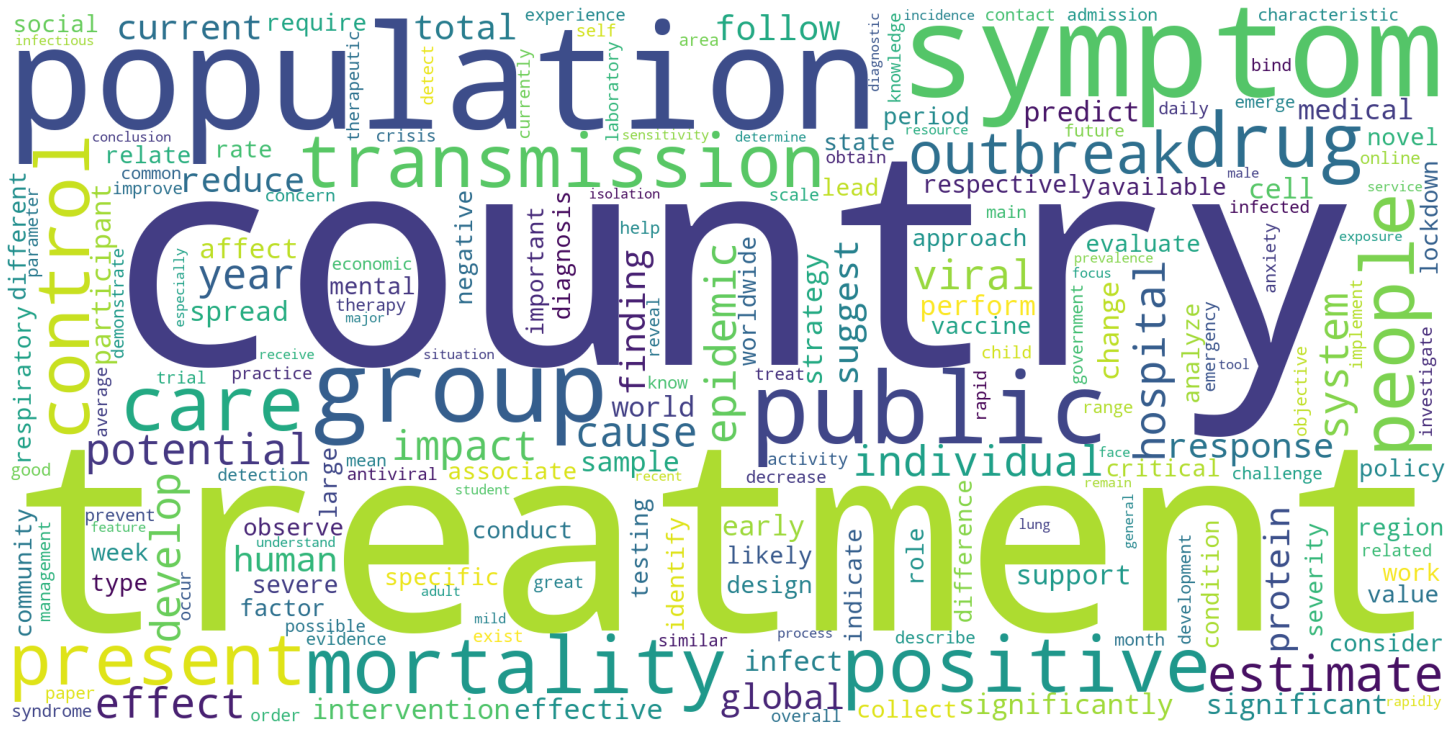

Text(0.5, 1.0, 'Word Cloud: Most Common Ariticles within the abstracts')

In [602]:

data['Lemma_Tokens'] = data_ready


for tokens in list(data['Lemma_Tokens']):
    abstract_tokens += tokens
wordcnt_dict = collections.Counter(abstract_tokens)

wcloud = WordCloud(width=2000, height=1000, background_color='white')
wcloud.generate_from_frequencies(wordcnt_dict)
fig,ax = plt.subplots(figsize=(20,10))
ax.imshow(wcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

ax.set_title('Word Cloud: Most Common Ariticles within the abstracts' ,fontsize=14)


# LDA Topic Extraction and TSNE topic modelling 


In [603]:
# Create Dictionary
id2token = corpora.Dictionary(list(data['Lemma_Tokens']))

# Create Corpus 
corpus = [id2token.doc2bow(tokens) for tokens in list(data['Lemma_Tokens'])]




/Users/camilorose/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [604]:
# After trialing several number of topics there appears to be ten disctinct ones within the corpus
# Building the LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2token,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       iterations=100,
                                       decay=0.5,
                                       per_word_topics=True,)



/Users/camilorose/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Visualising the results of the of LDA model

/Users/camilorose/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-605-9190755baa7f>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=words, fontsize=10)


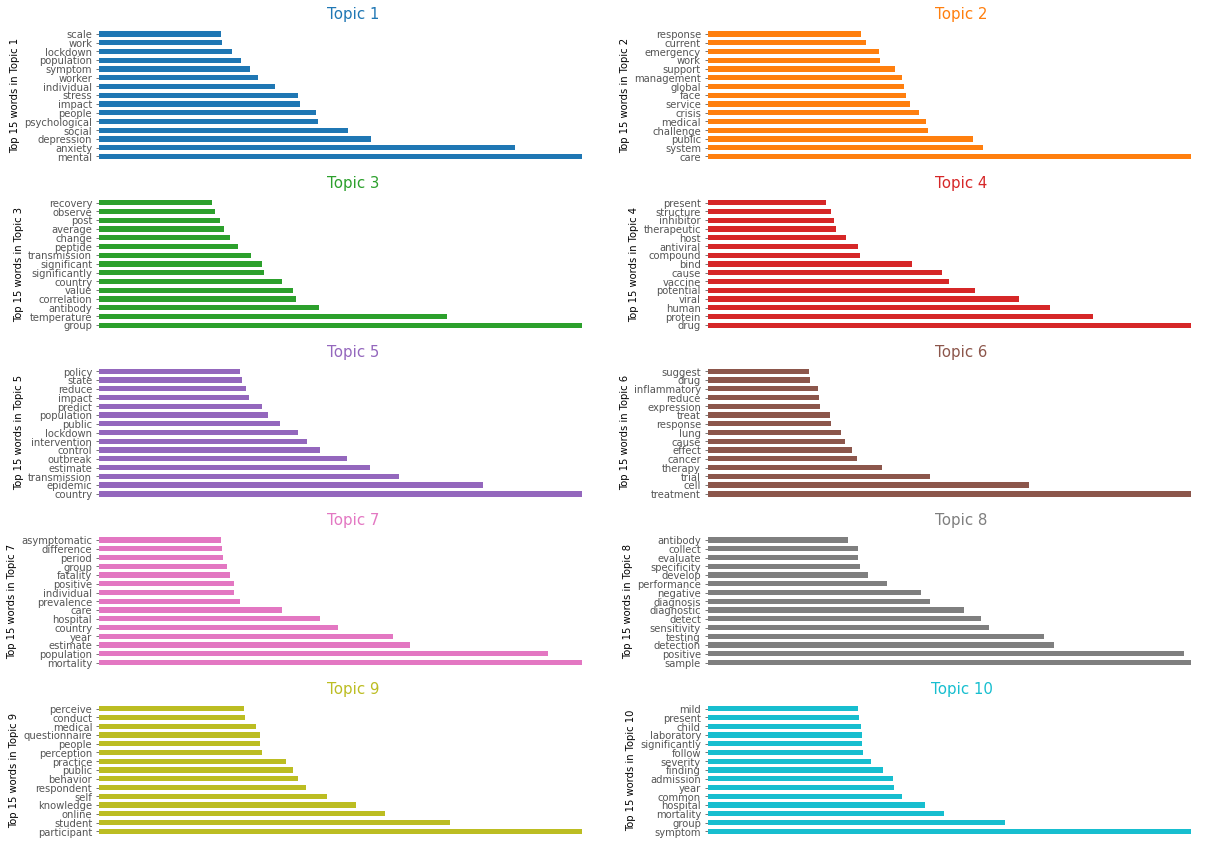

In [605]:
word_topic_scores = lda_model.show_topics(num_words=15,formatted=False)
word_topic_scores

    
fig = plt.figure(figsize=(20,15))
for i,topic in enumerate(word_topic_scores):
    word_score_pairs = topic[1]
    

    words = [word_score_pair[0] for word_score_pair in word_score_pairs]
    
    probs = [word_score_pair[1] for word_score_pair in word_score_pairs]
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    
    ax = fig.add_subplot(5,2,i+1)
    ax.barh(y=words,width=probs,height=0.6,color=cols[i])
    ax.set_yticklabels(labels=words, fontsize=10)
    ax.set_xticks([])
    ax.set_facecolor('white')
    ax.set_ylabel(f'Top 15 words in Topic {i+1}', fontsize=10)
    ax.yaxis.label.set_color('black')
    ax.set_title(f'Topic {i+1}', color=cols[i], fontsize=15)
   
   
    
    
    for pos in ['left','right','bottom','top']:
        ax.spines[pos].set_color(None)

/Users/camilorose/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


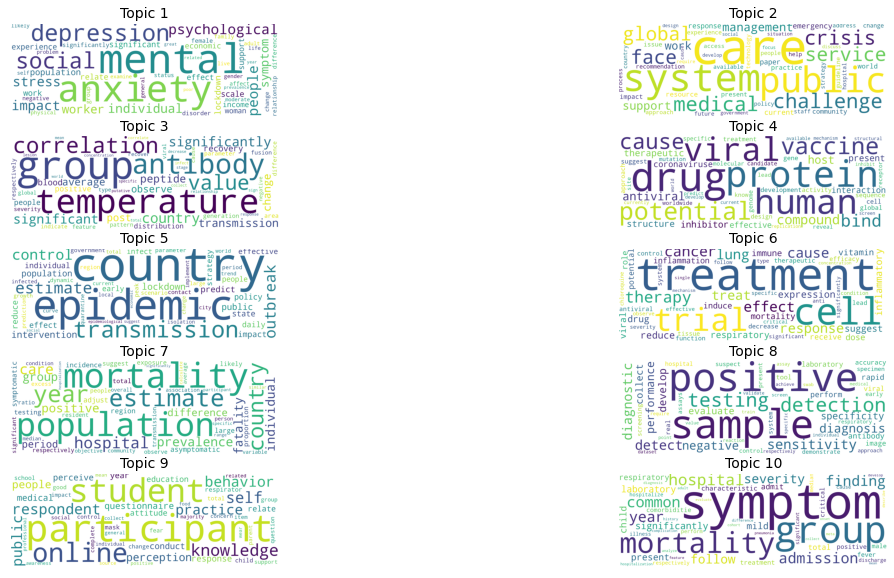

In [607]:
# Wordclouds with the top 50 words in each topic
word_topic_scores = lda_model.show_topics(num_words=50,formatted=False)
fig = plt.figure(figsize=(20,10))

for i,topic in enumerate(word_topic_scores):
    word_score_pairs = topic[1]
    
#     #word_score_dict = dict(topic[1])
    words = [word_score_pair[0] for word_score_pair in word_score_pairs]
    
    probs = [word_score_pair[1] for word_score_pair in word_score_pairs]
    words_prob_pairs = dict(zip(words, probs))
        #probs = [word_score_pair[1] for word_score_pair in word_score_pairs]
    ax= fig.add_subplot(5,2,i+1)
    wcloud = WordCloud(width=2000, height=700,background_color='white')
    wcloud.generate_from_frequencies(words_prob_pairs)
    ax.imshow(wcloud)
    for pos in ['left','right','top','bottom']:
        ax.spines[pos].set_color(None)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Topic {i+1}' ,fontsize=14)

/Users/camilorose/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-608-d6944b007d00>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-608-d6944b007d00>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-608-d6944b007d00>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<

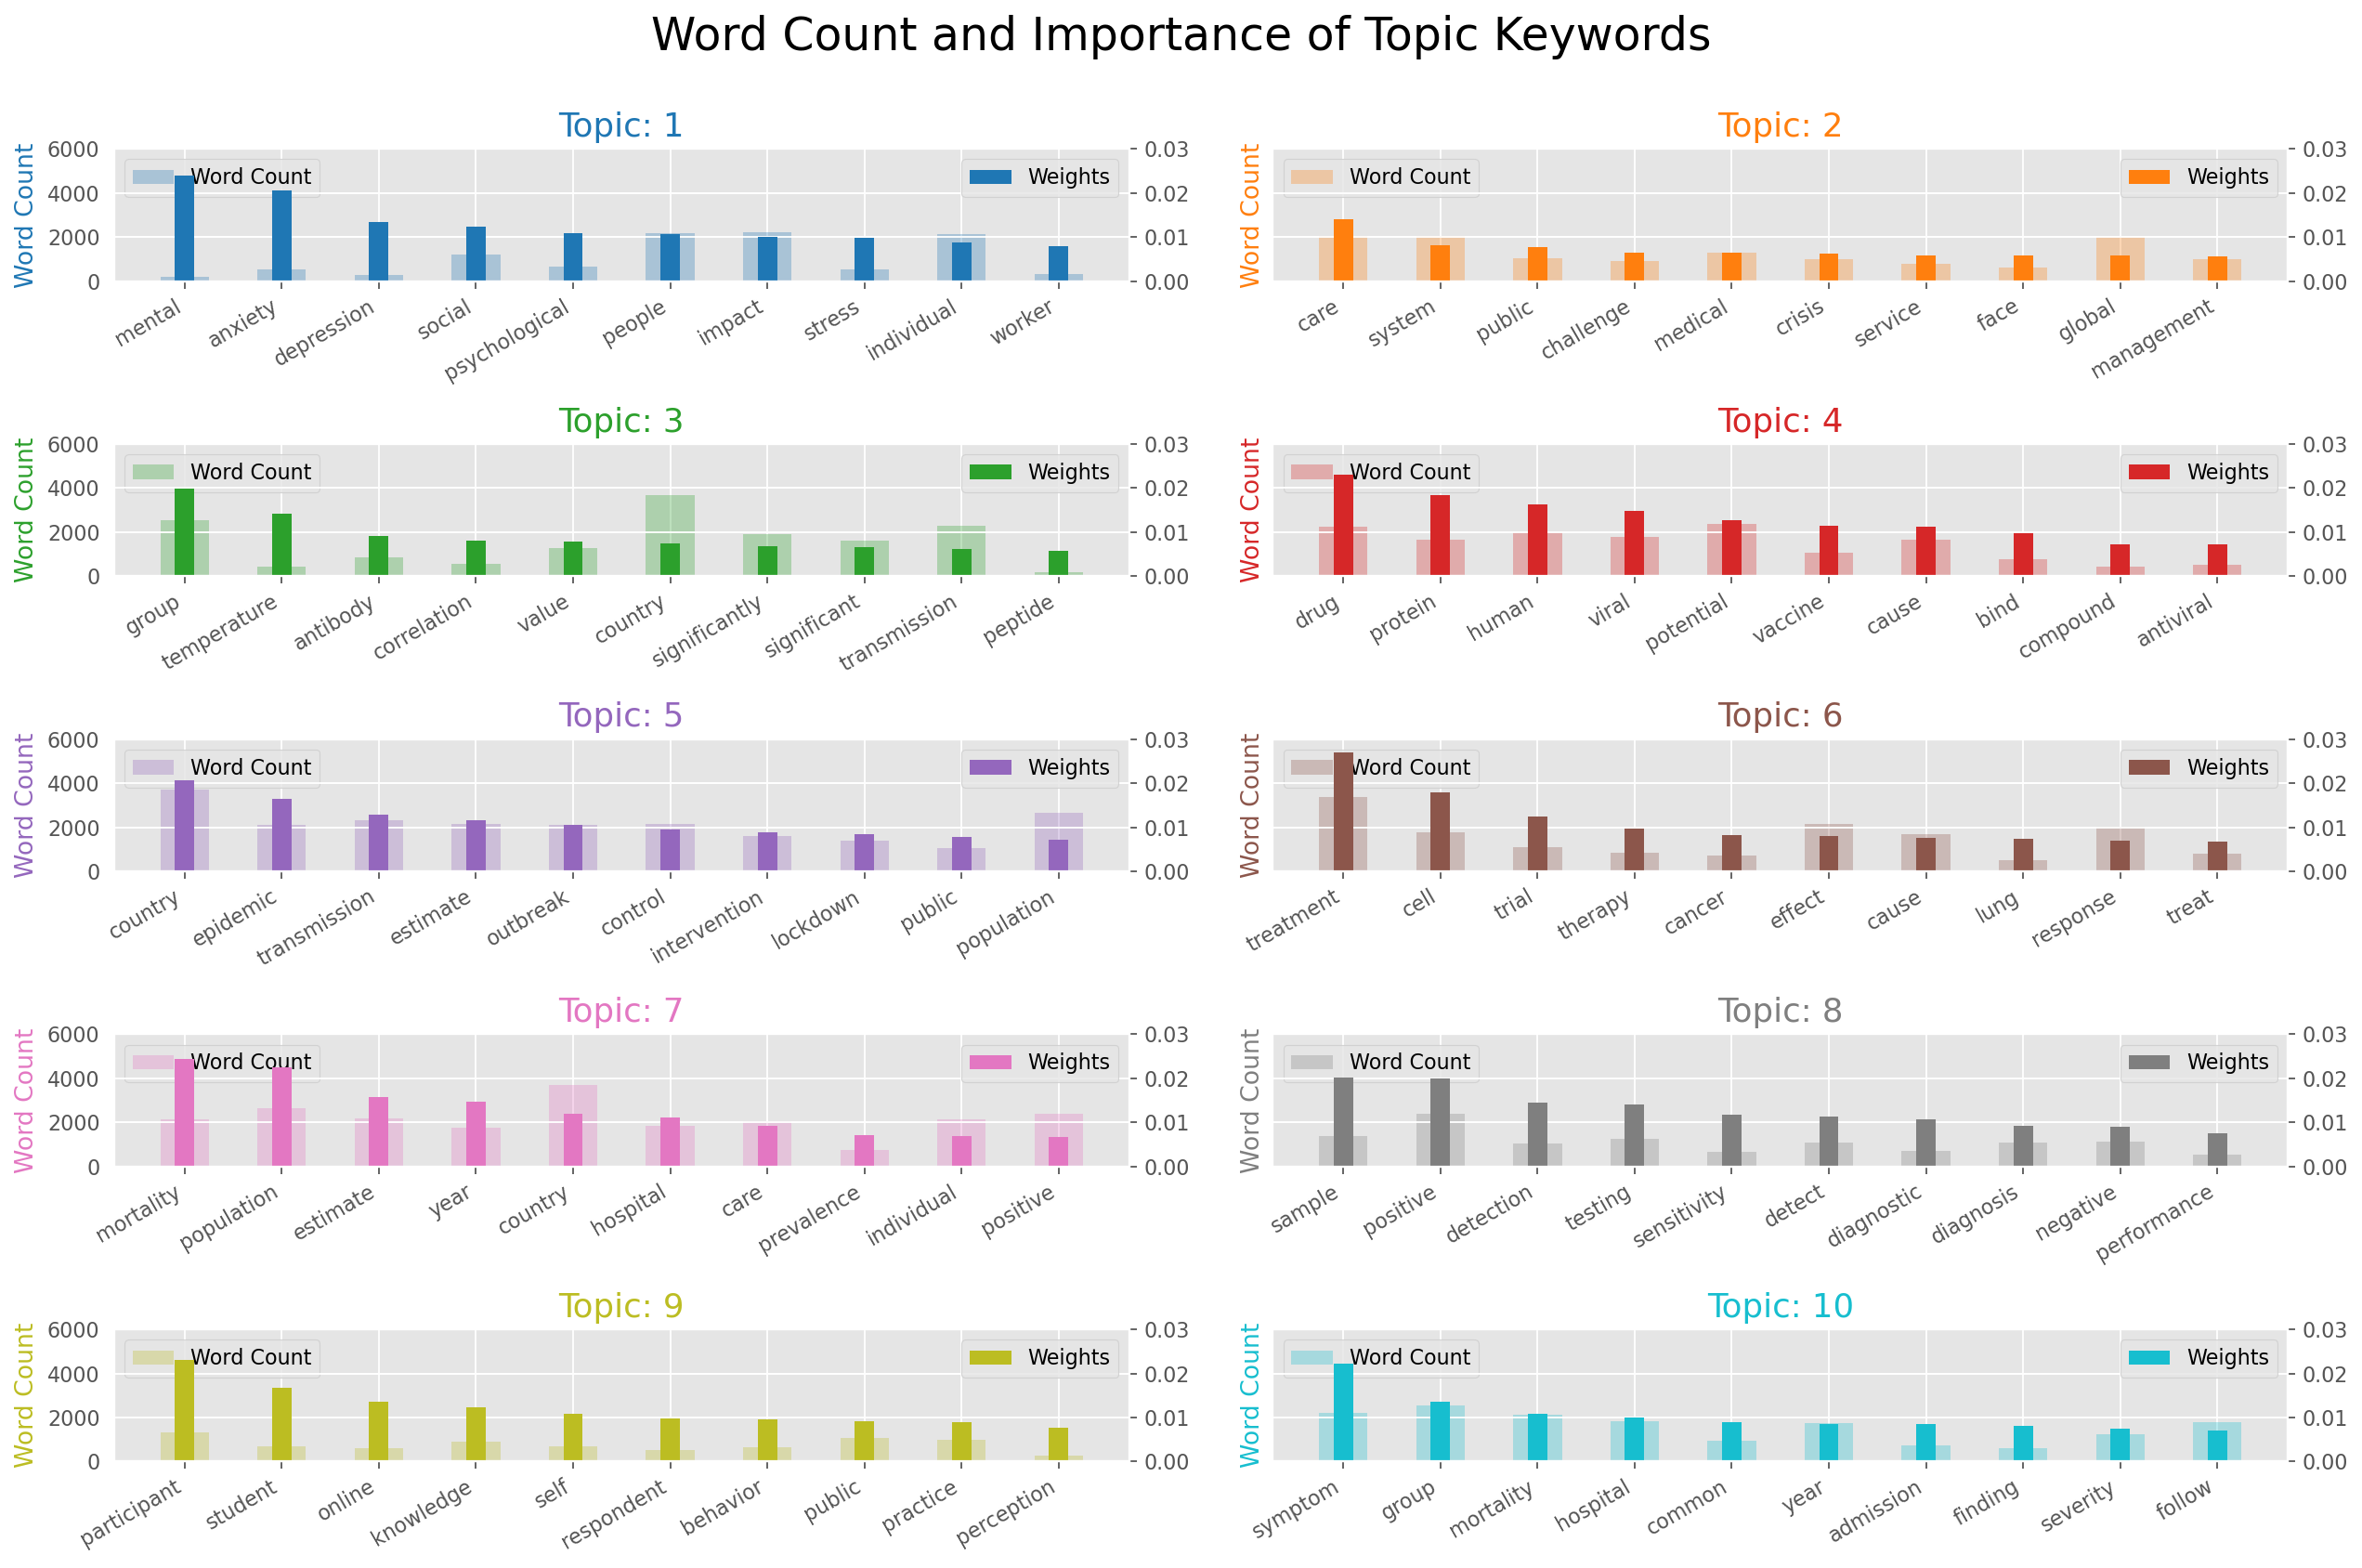

In [608]:
# Visualising the Word Counts within topics idea and method  from 
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = collections.Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 6000)
    ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [609]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2token)
vis

/Users/camilorose/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.024611  0.060043       1        1  16.724447
1      0.056571  0.186295       2        1  15.978566
3     -0.190259  0.151850       3        1  12.613107
9     -0.025748 -0.193433       4        1  11.497419
5     -0.147864 -0.044685       5        1   9.722919
7     -0.078256  0.018693       6        1   8.777178
6      0.064041 -0.113857       7        1   7.582072
8      0.198701  0.064587       8        1   6.872707
0      0.172066 -0.033984       9        1   6.093169
2     -0.073864 -0.095511      10        1   4.138414, topic_info=              Term         Freq        Total Category  logprob  loglift
871           drug  2662.000000  2662.000000  Default  30.0000  30.0000
128      mortality  2865.000000  2865.000000  Default  29.0000  29.0000
604      treatment  3457.000000  3457.000000  Default  28.0000  28.0000
478       estimate  2484.000000  2484.000000  Default  27.0000  27.0000
374        country  4226.000000  4226.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
109   respectively   119.477627  1637.568235  Topic10  -5.5783   0.5670
1240      severity   113.506363  1284.968753  Topic10  -5.6296   0.7582
512       indicate   109.947493  1146.978281  Topic10  -5.6615   0.8400
365           type   104.797513  1172.790999  Topic10  -5.7094   0.7697
371          cause   106.843939  3169.962240  Topic10  -5.6901  -0.2052

[785 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
620       4  0.978354    abnormality
620       5  0.015448    abnormality
620      10  0.005149    abnormality
3286      5  0.979125       abundant
4855     10  0.939480  acceptability
...     ...       ...            ...
145       7  0.379928           year
145       8  0.145136           year
145       9  0.067020           year
145      10  0.014203           year
619       3  0.989788       zoonotic

[2873 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 10, 6, 8, 7, 9, 1, 3])

# TNSE Clustering


In [610]:
# Generate document topic matrix
document_topic_matrix = np.zeros((len(corpus),10))
for idx,document_topic in enumerate(document_topic_distribution):
    for topic_idx,prob in document_topic:
        document_topic_matrix[idx][topic_idx] = prob
pd.DataFrame(document_topic_matrix).head()

/Users/camilorose/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.000000,0.000000,0.000000,0.986148,0.0,0.0,0.0,0.000000,0.0
1,0.000000,0.044956,0.000000,0.324702,0.586473,0.0,0.0,0.0,0.037714,0.0
2,0.383959,0.000000,0.586383,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
3,0.476970,0.000000,0.000000,0.233816,0.000000,0.0,0.0,0.0,0.275989,0.0
4,0.112807,0.244621,0.000000,0.000000,0.632530,0.0,0.0,0.0,0.000000,0.0


In [618]:


# Dominant topic number in each doc
topic_num = np.argmax(document_topic_matrix, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(document_topic_matrix)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 10
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])

title= list(data['title'])

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])

show(plot)

/Users/camilorose/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12028 samples in 0.063s...
[t-SNE] Computed neighbors for 12028 samples in 0.806s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12028
[t-SNE] Computed conditional probabilities for sample 2000 / 12028
[t-SNE] Computed conditional probabilities for sample 3000 / 12028
[t-SNE] Computed conditional probabilities for sample 4000 / 12028
[t-SNE] Computed conditional probabilities for sample 5000 / 12028
[t-SNE] Computed conditional probabilities for sample 6000 / 12028
[t-SNE] Computed conditional probabilities for sample 7000 / 12028
[t-SNE] Computed conditional probabilities for sample 8000 / 12028
[t-SNE] Computed conditional probabilities for sample 9000 / 12028
[t-SNE] Computed conditional probabilities for sample 10000 / 12028
[t-SNE] Computed conditional probabilities for sample 11000 / 12028
[t-SNE] Computed conditional probabilities for sample 12000 / 12028
[t-SNE] Computed conditional probabilities for sam

Loading BokehJS ...

# Clustering Documents with K-Means Clustering¶
Using the method described in https://www.kaggle.com/jswxhd/risk-factor-mining-cord-19-articles-2021 as a comparison for the results I obtained
from the LDA Clusterings

In [612]:
from sentence_transformers import SentenceTransformer
sentences = list(data['Lemma_Tokens'].apply(lambda x: ' '.join(x)))
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(sentences, show_progress_bar=True)

/Users/camilorose/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Batches:   0%|          | 0/376 [00:00<?, ?it/s]

In [613]:
num_clusters = 10
clustering_model = KMeans(n_clusters=num_clusters,
                          n_init=10,
                          max_iter=300,
                          tol=1e-4,
                          random_state=98)
clustering_model.fit(embeddings)
cluster_assignment = clustering_model.labels_

/Users/camilorose/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [614]:
df_docs = pd.DataFrame(sentences,columns=['Doc'])
df_docs['Topic'] = cluster_assignment
df_docs['Doc_ID'] = range(len(df_docs))
docs_per_topic = df_docs.groupby(['Topic'],as_index=False).agg({'Doc':' '.join})
docs_per_topic

/Users/camilorose/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic,Doc
0,0,classified group group isolation group symptom...
1,1,indian suicide turn press medium attention flo...
2,2,year year main symptom similar incidence diffe...
3,3,coronaviruse represent major group affect zoon...
4,4,implementation learning islamic student islami...
5,5,face development vaccine challenge proportion ...
6,6,significant cardiovascular morbidity mortality...
7,7,large observational data network leverage rout...
8,8,background objective epidemic unprecedently af...
9,9,objective global public emergency important di...


In [615]:
from sklearn.feature_extraction.text import CountVectorizer

def c_TF_IDF(documents, m, ngram_range=(1, 2), min_df=3):
    bow = CountVectorizer(ngram_range=ngram_range, 
                          stop_words="english",
                          min_df = min_df,)
    bow.fit(documents)
    bow_matrix = bow.transform(documents).toarray()
    w = np.sum(bow_matrix,axis=1)
    tf = np.divide(bow_matrix.T, w)
    sum_t = np.sum(bow_matrix,axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)
    
    return tf_idf, bow

c_tf_idf, bow = c_TF_IDF(docs_per_topic.Doc.values,m=len(sentences))
print(f'The shape of cluster tf-idf matrix is {c_tf_idf.shape}')

/Users/camilorose/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The shape of cluster tf-idf matrix is (35328, 10)


In [616]:
def extract_top_n_words_per_topic(tf_idf, bow, docs_per_topic, n=20):
    words = bow.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {}
    for i,label in enumerate(labels):
        for j in indices[i]:
            if label not in top_n_words:
                top_n_words[label] = [(words[j],tf_idf_transposed[i][j])]
            else:
                top_n_words[label].append((words[j],tf_idf_transposed[i][j]))
        top_n_words[label] = top_n_words[label][::-1]
    
    return top_n_words

top_n_words = extract_top_n_words_per_topic(c_tf_idf,bow,docs_per_topic)

/Users/camilorose/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/camilorose/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


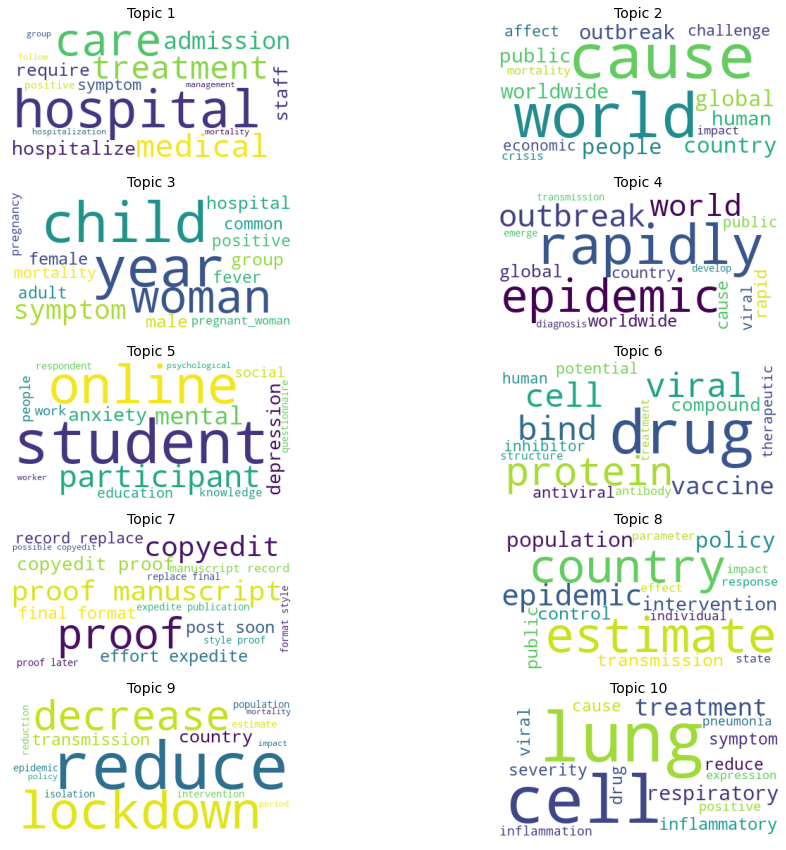

In [617]:
fig = plt.figure(figsize=(16,15))
for label,word_prob_pairs in top_n_words.items():
    top_15_words_prob_pairs = dict(word_prob_pairs[:15])
    #probs = [word_score_pair[1] for word_score_pair in word_score_pairs]
    ax= fig.add_subplot(5,2,label+1)
    wcloud = WordCloud(background_color='white')
    wcloud.generate_from_frequencies(top_15_words_prob_pairs)
    ax.imshow(wcloud)
    for pos in ['left','right','top','bottom']:
        ax.spines[pos].set_color(None)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Topic {label+1}' ,fontsize=14)